In [2]:
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
%matplotlib inline

class CrankNicolsonBS:
    def __init__(self, Typeflag, cpflag, S0, K, T, vol, r, d):
        self.Typeflag = Typeflag
        self.cpflag = cpflag
        self.S0 = S0
        self.K = K
        self.T = T
        self.vol = vol
        self.r = r
        self.d = d
        
    def CN_option_info(self, Typeflag, cpflag, S0, K, T, vol, r, d):
        mu = (r-d-0.5*vol*vol)
        
        # range x in [-x_max, x_max]
        x_max = vol*np.sqrt(T)*5
        
        #number of steps along x
        N = 500
        dx = 2*x_max/N

        # grid along x dimension:
        X = np.linspace(-x_max,x_max,N+1)
        n = np.arange(0,N+1)

        #number of time steps
        J = 600
        dt = T/J
        
        #grid along time dimension:
        Tau = np.arange(J)*dt
        
        # set up the matrix
        a = 0.25*dt*vol*vol/(dx*dx)
        b = 0.25*dt*mu/dx
        c = 0.5*dt*r
        
        A = (1+c+2*a)*np.eye(N+1) + (-a-b)*np.eye(N+1,k=1) + (b-a)*np.eye(N+1,k=-1)
        B = (1-c-2*a)*np.eye(N+1) + (a+b)*np.eye(N+1,k=1) + (a-b)*np.eye(N+1,k=-1)
        Ainv = np.linalg.inv(A)
        
        if cpflag == 'c':
            # Option payoff at maturity
            V = np.clip(S0*np.exp(X)-K,0,1e10)
        elif cpflag == 'p':
            V = np.clip(K-S0*np.exp(X),0,1e10)
        
        cut = int(N/4)

        if Typeflag == 'Am':
            V0 = V.copy()
            for j in range(J):
                if j == J-1:
                    V1 = V
                V = B.dot(V)
                V = Ainv.dot(V)
                # apply early exercise boundary conditions:
                V = np.where(V>V0, V, V0)
                if j%50==0: plt.plot(S0*np.exp(X[cut:-cut]), V[cut:-cut]) 
        
        if Typeflag == 'Bmd':
            V0 = V.copy()
            for j in range(J):
                if j == J-1:
                    V1 = V
                V = B.dot(V)
                V = Ainv.dot(V)
                # apply early exercise boundary conditions:
                if j%50==0:
                    V = np.where(V>V0,V,V0)
                if J%50==0: plt.plot(S0*np.exp(X[cut:-cut]), V[cut:-cut]) 
                
        elif Typeflag == 'Eu':
            for j in range(J):
                if j == J-1:
                    V1 = V
                V = B.dot(V)
                V = Ainv.dot(V)
                V[0] = 0
                V[N] = S0*np.exp(x_max) - K*np.exp(-r*j*dt)
                if j%50==0: plt.plot(S0*np.exp(X[cut:-cut]), V[cut:-cut])
                    
        #mid grid point:
        n_mid = int(N/2)
        price = V[n_mid]
        delta = (V[n_mid+1]-V[n_mid-1])/(S0*np.exp(dx)-S0*np.exp(-dx))
        gamma = ((V[n_mid+1]-V[n_mid])/(S0*(np.exp(dx)-1))-(V[n_mid]-V[n_mid-1])/(S0*(1-np.exp(-dx))))/(S0*np.exp(dx)-S0*np.exp(-dx))*2
        theta = -(V[n_mid]-V1[n_mid])/(dt)
        
        return price, delta, gamma, theta


Bermuda Call
Price: 15.905934880191543 
Delta 0.5775871939005949 
Gamma: 0.00962582396570593 
Theta: -7.739774797178355


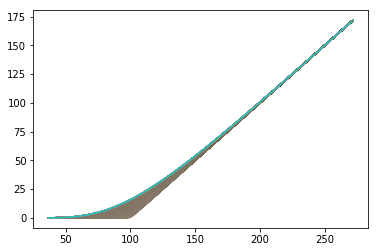

In [4]:
#Bermuda Call
Bmd_call = CrankNicolsonBS('Bmd', 'c', 100, 100, 1, 0.4, 0.025, 0.0175)
Bmd_call_info = Bmd_call.CN_option_info('Bmd', 'c', 100, 100, 1, 0.4, 0.025, 0.0175)
print('Bermuda Call\nPrice:',Bmd_call_info[0],'\nDelta',Bmd_call_info[1],'\nGamma:',Bmd_call_info[2],'\nTheta:',Bmd_call_info[3])

Bermuda Put
Price: 15.255421326262725 
Delta -0.41082965544008715 
Gamma: 0.009784718170702405 
Theta: -7.141821862239083


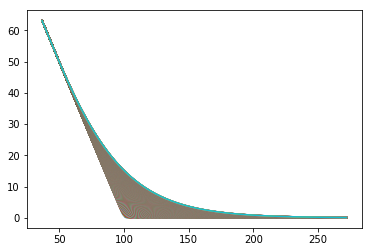

In [6]:
#Bermuda Put
Bmd_put = CrankNicolsonBS('Bmd', 'p', 100, 100, 1, 0.4, 0.025, 0.0175)
Bmd_put_info = Bmd_put.CN_option_info('Bmd', 'p', 100, 100, 1, 0.4, 0.025, 0.0175)
print('Bermuda Put\nPrice:',Bmd_put_info[0],'\nDelta',Bmd_put_info[1],'\nGamma:',Bmd_put_info[2],'\nTheta:',Bmd_put_info[3])

In [86]:
def CN_Barrier_option(Typeflag, cpflag, S0, K, Hu, Hd, T, vol, r, d):
    mu = (r-d-0.5*vol*vol)

    # range x in [-x_max, x_max]
    x_max = vol*np.sqrt(T)*5

    #number of steps along x
    N = 500
    dx = 2*x_max/N

    # grid along x dimension:
    X = np.linspace(-x_max,x_max,N+1)
    n = np.arange(0,N+1)

    #number of time steps
    J = 600
    dt = T/J

    #grid along time dimension:
    Tau = np.arange(J)*dt

    # set up the matrix
    a = 0.25*dt*vol*vol/(dx*dx)
    b = 0.25*dt*mu/dx
    c = 0.5*dt*r

    A = (1+c+2*a)*np.eye(N+1) + (-a-b)*np.eye(N+1,k=1) + (b-a)*np.eye(N+1,k=-1)
    B = (1-c-2*a)*np.eye(N+1) + (a+b)*np.eye(N+1,k=1) + (a-b)*np.eye(N+1,k=-1)
    Ainv = np.linalg.inv(A)
    
    if cpflag == 'c':
        # Option payoff at maturity
        V = np.where(np.logical_and(S0*np.exp(X)>K,S0*np.exp(X)<Hu),S0*np.exp(X)-K,0)
    elif cpflag == 'p':
        V = np.where(np.logical_and(S0*np.exp(X)<K,np.logical_and(S0*np.exp(X)<Hu,S0*np.exp(X)>Hd)),K-S0*np.exp(X),0)
    
    cut = int(N/4)

    if Typeflag == 'UNO':
        for j in range(J):
            if j == J-1:
                V1 = V
            V = B.dot(V)
            V = Ainv.dot(V)
            V = np.where(S0*np.exp(X)<Hu,V,0)
            if j%50==0: plt.plot(S0*np.exp(X[cut:-cut]), V[cut:-cut])
    
    if Typeflag == 'DNO':
        for j in range(J):
            if j == J-1:
                V1 = V
            V = B.dot(V)
            V = Ainv.dot(V)
            V = np.where(np.logical_and(S0*np.exp(X)<Hu,S0*np.exp(X)>Hd),V,0)
            if j%50==0:
                plt.plot(S0*np.exp(X[cut:-cut]), V[cut:-cut])
                plt.subplot(212)
            V_temp = V[cut:-cut]
            X_temp = X[cut:-cut]
            DNO_Gamma = (V_temp[2:]-2*V_temp[1:-1]+V_temp[:-2])/(dx*dx*S0*np.exp(X_temp[1:-1])*S0*np.exp(X_temp[1:-1]))-(V_temp[2:]-V_temp[:-2])/2/(dx*S0*np.exp(X_temp[1:-1])*S0*np.exp(X_temp[1:-1]))
            plt.plot(S0*np.exp(X_temp[1:-1]),DNO_Gamma)
            plt.subplot(211)
        
    #mid grid point:
    n_mid = int(N/2)
    price = V[n_mid]
    delta = (V[n_mid+1]-V[n_mid-1])/(S0*np.exp(dx)-S0*np.exp(-dx))
    gamma = ((V[n_mid+1]-V[n_mid])/(S0*(np.exp(dx)-1))-(V[n_mid]-V[n_mid-1])/(S0*(1-np.exp(-dx))))/(S0*np.exp(dx)-S0*np.exp(-dx))*2
    theta = -(V[n_mid]-V1[n_mid])/(dt)

    return price, delta, gamma, theta

(0.01922012095255495,
 -0.0007380366679723496,
 -2.1773658120752058e-05,
 0.028307407343420434)

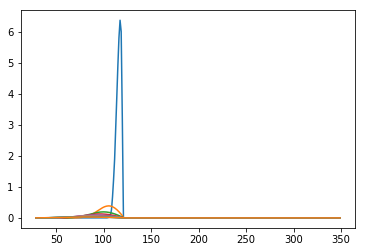

In [87]:
#Up-and-out Call ('UNO','c',100,110,120,0,1,0.5,0.025,0.0175)
CN_Barrier_option('UNO','c',100,110,120,0,1,0.5,0.025,0.0175)

(9.818671335220104,
 -0.4723258930977912,
 0.002813323187626729,
 -2.9206524739063155)

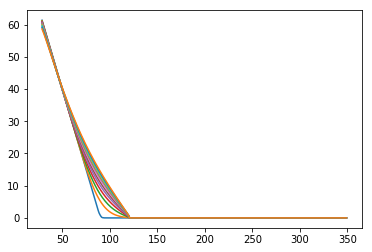

In [88]:
#Up-and-out Put ('UNO','p',100,90,120,0,1,0.5,0.025,0.0175)
CN_Barrier_option('UNO','p',100,90,120,0,1,0.5,0.025,0.0175)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0.0014391970492223134,
 -8.521672986351507e-06,
 -7.610191795741399e-06,
 0.009608349615198176)

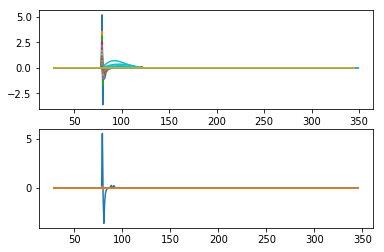

In [89]:
#Double knock-out Put ('DNO','p',100,90,120,80,1,0.5,0.025,0.0175)
CN_Barrier_option('DNO','p',100,90,120,80,1,0.5,0.025,0.0175)